In [11]:
# Block 1: Импорт библиотек
# =============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from datetime import datetime
import tensorflow as tf
import logging
from pickle import dump, load

# Подавление предупреждений TensorFlow
tf.get_logger().setLevel(logging.ERROR)


In [12]:
# Block 2: Загрузка данных и первичный анализ
# =============================================================
def load_and_inspect_data(file_path):
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
    df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
    print("\n========== Первые 5 строк датасета ==========")
    print(df.head())
    print("\n========== Размерность набора данных ==========")
    print(f"Размерность набора данных: {df.shape}")
    print("\n========== Типы атрибутов ==========")
    print(df.dtypes)
    print("\n========== Информация о данных ==========")
    df.info()
    print("\n========== Уникальные значения в столбце 'origin' ==========")
    print(df['origin'].value_counts())
    print("\n========== Описание числовых признаков ==========")
    print(df.describe())
    return df


In [13]:
# Block 3: Визуализация данных
# =============================================================
def visualize_data(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='origin', data=df)
    plt.title('Количество автомобилей по регионам происхождения')
    plt.xlabel('Регион происхождения')
    plt.ylabel('Количество')
    plt.show()

    df.hist(figsize=(12, 8))
    plt.suptitle('Гистограммы для всех признаков')
    plt.show()

    sns.pairplot(df)
    plt.suptitle('Парные графики для всех признаков', y=1.02)
    plt.show()

    plt.figure(figsize=(12, 14))
    plt.scatter(df['weight'], df['horsepower'], c=df['mpg'], cmap='viridis', alpha=0.6, s=df['cylinders']*10)
    plt.colorbar(label='MPG')
    plt.xlabel('Вес авто (weight)')
    plt.ylabel('Лошадиные силы')
    plt.title('Зависимость между весом авто, лошадиными силами и расходом топлива (MPG)')
    plt.show()


In [14]:
# Block 4: Очистка данных
# =============================================================
def clean_data(df):
    df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
    df['hppercil'] = df['horsepower'] / df['cylinders']
    df.drop(columns=['car_name'], inplace=True)
    for column in df.columns:
        df[column] = df[column].replace('?', np.nan)
    return df


In [15]:
# Block 5: Корреляционный анализ
# =============================================================
def correlation_analysis(df):
    print("========== Матрица корреляции ==========")
    corr_matrix = df.corr()
    print(corr_matrix)

    print("========== Корреляция с 'mpg' ==========")
    correlation_target = corr_matrix['mpg'].sort_values(ascending=False)
    print(correlation_target)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
    plt.title('Тепловая карта корреляции для всех признаков')
    plt.show()


In [16]:
# Block 6: Разделение данных на обучающую и тестовую выборки
# =============================================================
def split_data(df, target_column='mpg'):
    X_full = df.drop(columns=[target_column])
    y = df[target_column]
    X_filtered = df[['cylinders', 'horsepower', 'weight']]
    return X_full, X_filtered, y


In [17]:
# Block 7: Определение категориальных и числовых признаков
# =============================================================
def define_features():
    categorical_features = []
    numerical_features_full = ['cylinders', 'horsepower', 'weight']
    numerical_features_filtered = ['cylinders', 'horsepower', 'weight']
    return categorical_features, numerical_features_full, numerical_features_filtered


In [18]:
# Block 8: Предобработка данных
# =============================================================
def create_preprocessors(numerical_features_full, numerical_features_filtered):
    preprocessor_full = ColumnTransformer(
        transformers=[('num', StandardScaler(), numerical_features_full)]
    )
    preprocessor_filtered = ColumnTransformer(
        transformers=[('num', StandardScaler(), numerical_features_filtered)]
    )
    scaler_full = StandardScaler()
    scaler_filtered = StandardScaler()
    return preprocessor_full, preprocessor_filtered, scaler_full, scaler_filtered


In [19]:
# Block 9: Определение моделей GRU
# =============================================================
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='RMSprop', loss='mse')
    return model


C:\Users\Dmitry\AppData\Local\Temp\ipykernel_15788\4178184078.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)



========== Первые 5 строк датасета ==========
    mpg  cylinders  displacement horsepower  weight  acceleration  model_year  \
0  18.0          8         307.0      130.0  3504.0          12.0          70   
1  15.0          8         350.0      165.0  3693.0          11.5          70   
2  18.0          8         318.0      150.0  3436.0          11.0          70   
3  16.0          8         304.0      150.0  3433.0          12.0          70   
4  17.0          8         302.0      140.0  3449.0          10.5          70   

   origin                   car_name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  

========== Размерность набора данных ==========
Размерность набора данных: (398, 9)

========== Типы атрибутов ==========
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight       

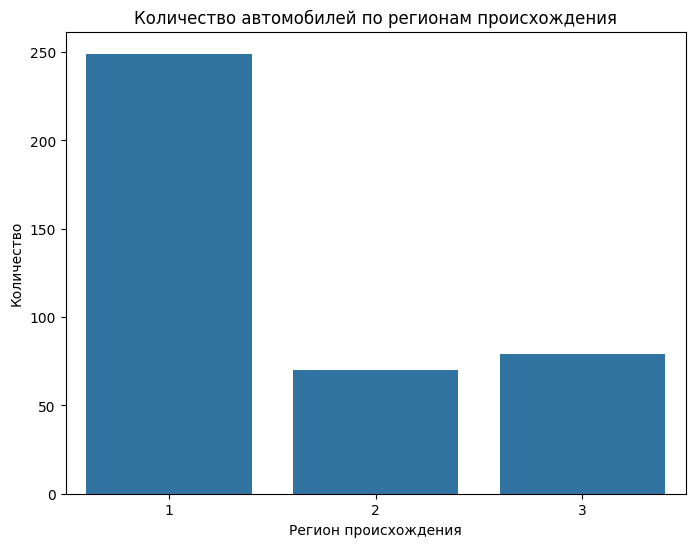

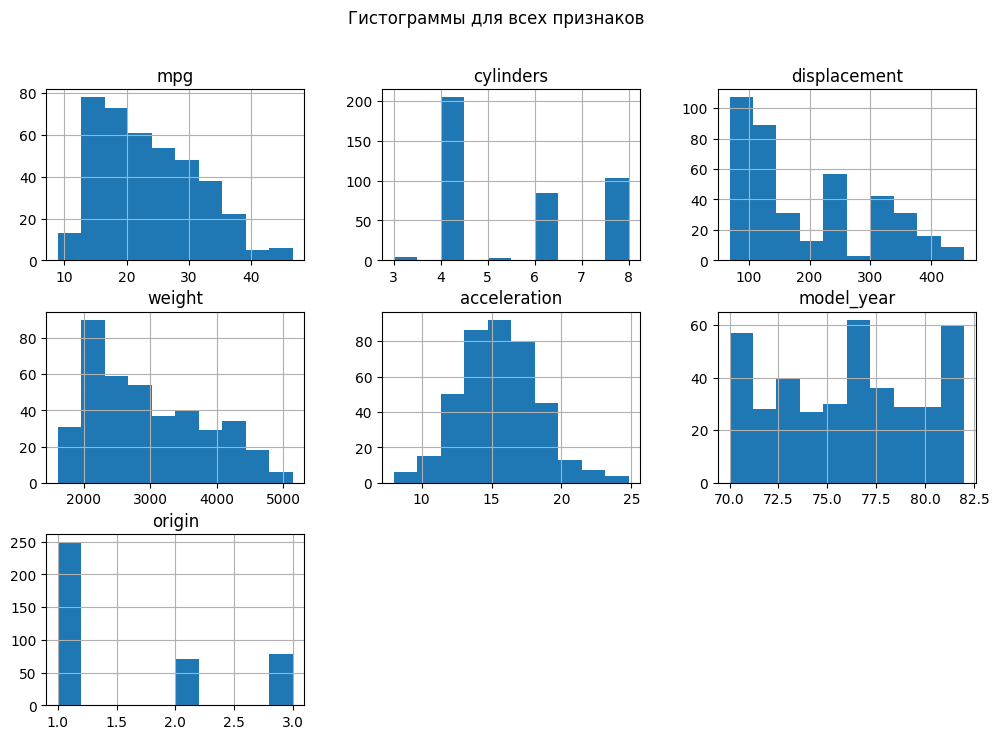

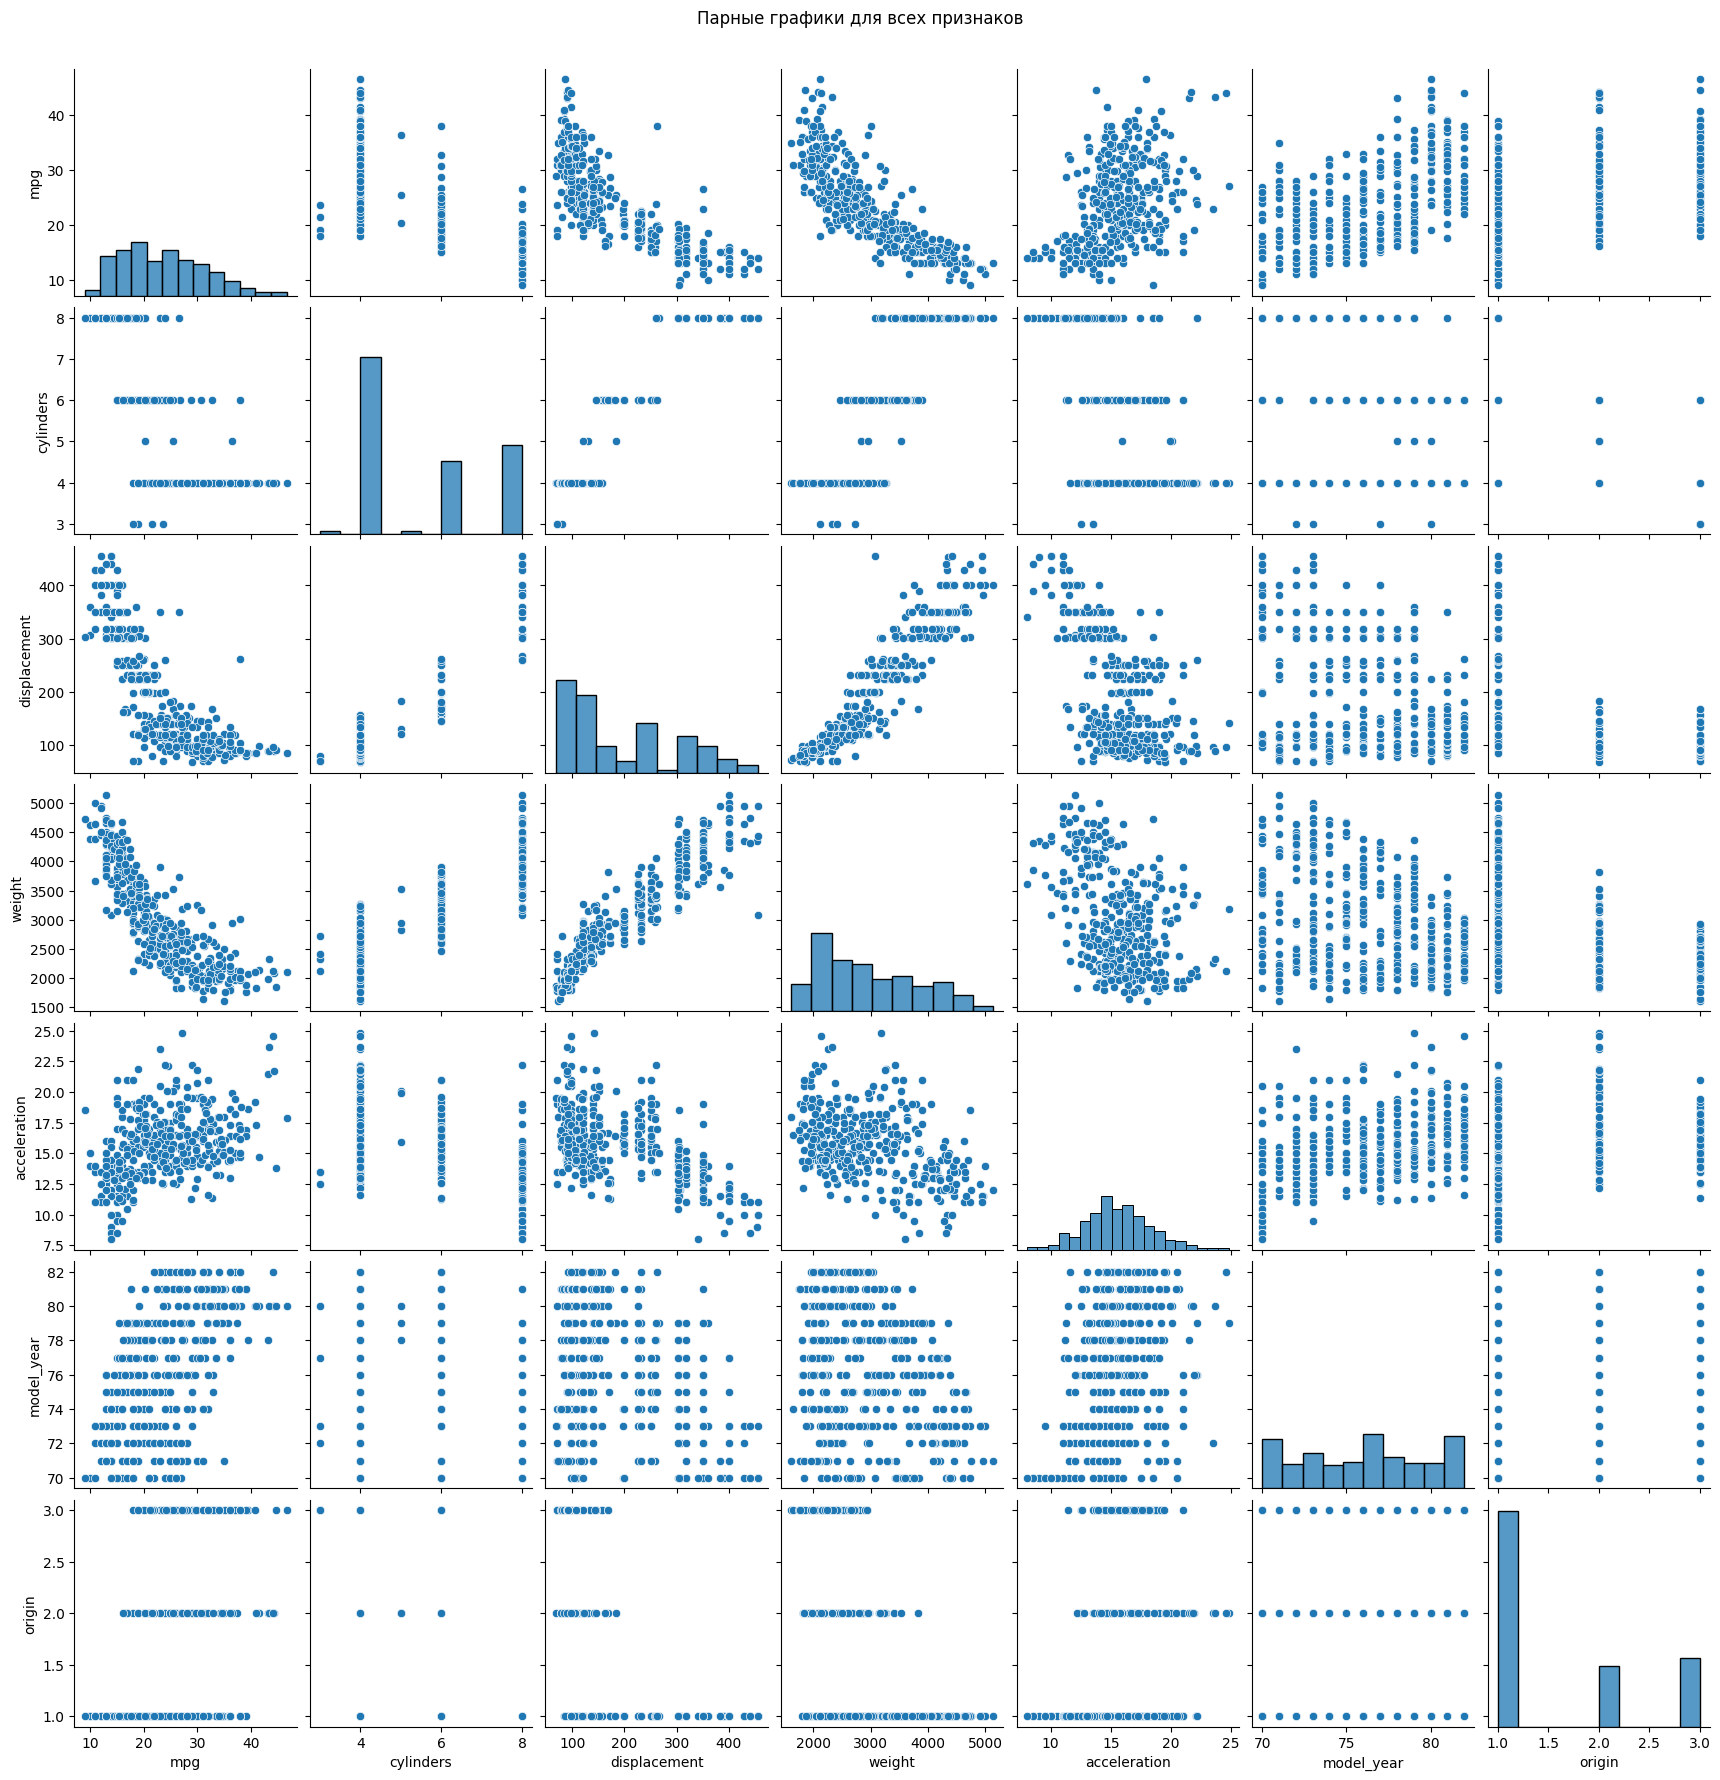

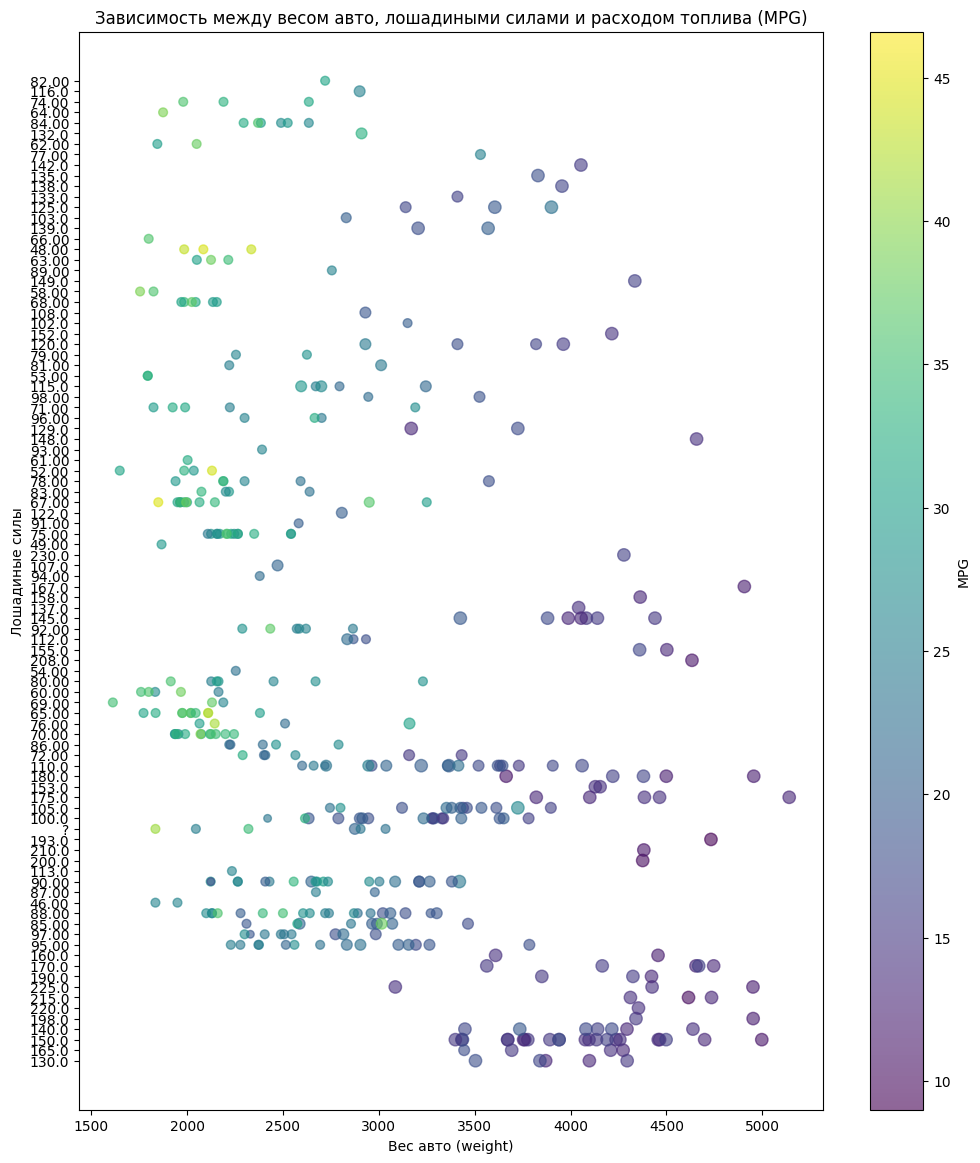

========== Матрица корреляции ==========
                   mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.775396     -0.804203   -0.773453 -0.831741   
cylinders    -0.775396   1.000000      0.950721    0.841284  0.896017   
displacement -0.804203   0.950721      1.000000    0.895778  0.932824   
horsepower   -0.773453   0.841284      0.895778    1.000000  0.862442   
weight       -0.831741   0.896017      0.932824    0.862442  1.000000   
acceleration  0.420289  -0.505419     -0.543684   -0.686590 -0.417457   
model_year    0.579267  -0.348746     -0.370164   -0.413733 -0.306564   
origin        0.563450  -0.562543     -0.609409   -0.452096 -0.581024   
hppercil     -0.213253  -0.085724      0.075692    0.437047  0.138797   

              acceleration  model_year    origin  hppercil  
mpg               0.420289    0.579267  0.563450 -0.213253  
cylinders        -0.505419   -0.348746 -0.562543 -0.085724  
displacement     -0.543684   -0.370164 -0.609

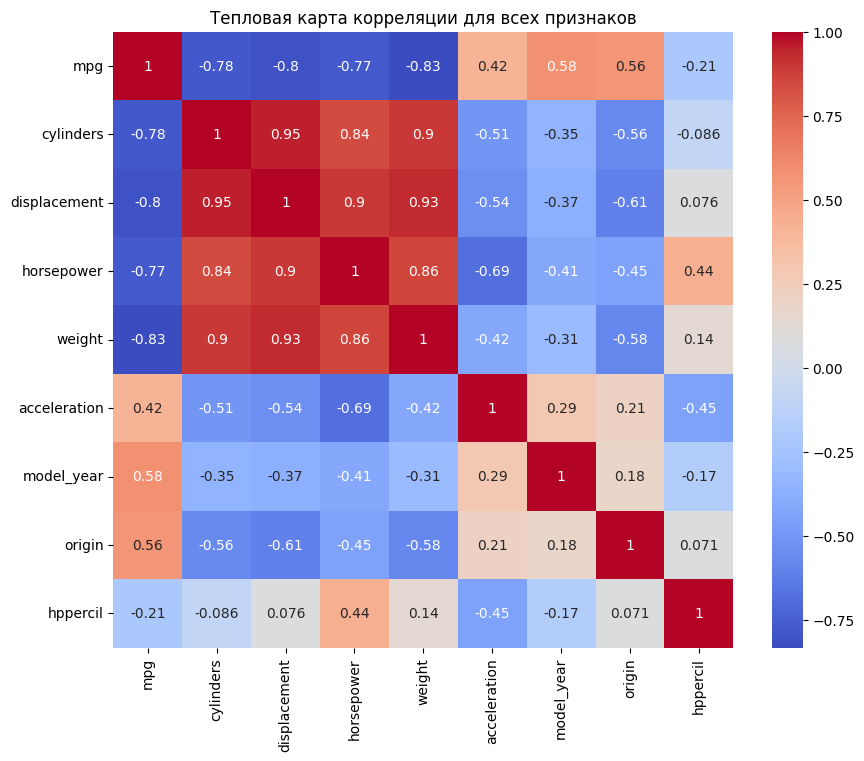

Epoch 1/240
10/10 [==============================] - 4s 10ms/step - loss: 595.4782
Epoch 2/240
10/10 [==============================] - 0s 9ms/step - loss: 527.3843
Epoch 3/240
10/10 [==============================] - 0s 8ms/step - loss: 337.6019
Epoch 4/240
10/10 [==============================] - 0s 9ms/step - loss: 189.2838
Epoch 5/240
10/10 [==============================] - 0s 10ms/step - loss: 166.5172
Epoch 6/240
10/10 [==============================] - 0s 8ms/step - loss: 153.8429
Epoch 7/240
10/10 [==============================] - 0s 9ms/step - loss: 140.4648
Epoch 8/240
10/10 [==============================] - 0s 9ms/step - loss: 128.4545
Epoch 9/240
10/10 [==============================] - 0s 10ms/step - loss: 122.4355
Epoch 10/240
10/10 [==============================] - 0s 9ms/step - loss: 115.0070
Epoch 11/240
10/10 [==============================] - 0s 9ms/step - loss: 106.3777
Epoch 12/240
10/10 [==============================] - 0s 9ms/step - loss: 98.4052
Epoch 13/24

In [20]:
# 10. Создание и обучение моделей
# =============================================================
def train_models(X_full, X_filtered, y, preprocessor_full, preprocessor_filtered, scaler_full, scaler_filtered):
    # разделение данных на обучающую и тестовую выборки с использованием train_test_split соответствует   этапу 5.1 в методических материалах.       
  # Разделение данных на обучающую и тестовую выборки (80% - обучение, 20% - тест)
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42)
    X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

    # Стандартизация данных и создание наборов данных для GRU
    X_train_full_prepared = preprocessor_full.fit_transform(X_train_full)
    X_test_full_prepared = preprocessor_full.transform(X_test_full)

    X_train_filtered_prepared = preprocessor_filtered.fit_transform(X_train_filtered)
    X_test_filtered_prepared = preprocessor_filtered.transform(X_test_filtered)

    # Стандартизация полных данных
    X_train_full_standardized = scaler_full.fit_transform(X_train_full)
    X_test_full_standardized = scaler_full.transform(X_test_full)

    # Стандартизация фильтрованных данных
    X_train_filtered_standardized = scaler_filtered.fit_transform(X_train_filtered[numerical_features_filtered])
    X_test_filtered_standardized = scaler_filtered.transform(X_test_filtered[numerical_features_filtered])

    # Добавление ранней остановки
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Обучение моделей GRU на различных данных
    # GRU Model 1: Полная модель
    gru_model_full = create_gru_model((X_train_full_prepared.shape[1], 1))
    gru_model_full.fit(np.expand_dims(X_train_full_prepared, axis=-1), y_train_full, epochs=240, batch_size=32,  callbacks=[early_stopping])

    # GRU Model 2: Фильтрованная модель
    gru_model_filtered = create_gru_model((X_train_filtered_prepared.shape[1], 1))
    gru_model_filtered.fit(np.expand_dims(X_train_filtered_prepared, axis=-1), y_train_filtered, epochs=240, batch_size=32,  callbacks=[early_stopping])

    # GRU Model 3: Полная модель с стандартизированными данными
    gru_model_full_standardized = create_gru_model((X_train_full_standardized.shape[1], 1))
    gru_model_full_standardized.fit(np.expand_dims(X_train_full_standardized, axis=-1), y_train_full, epochs=240, batch_size=32,  callbacks=[early_stopping])

    # GRU Model 4: Фильтрованная модель с стандартизацией
    gru_model_filtered_standardized = create_gru_model((X_train_filtered_standardized.shape[1], 1))
    gru_model_filtered_standardized.fit(np.expand_dims(X_train_filtered_standardized, axis=-1), y_train_filtered, epochs=240, batch_size=32,  callbacks=[early_stopping])

    return (gru_model_full, gru_model_filtered, gru_model_full_standardized, gru_model_filtered_standardized), X_train_full_prepared, X_test_full_prepared, y_train_full, y_test_full, X_train_filtered_prepared, X_test_filtered_prepared, y_train_filtered, y_test_filtered, X_train_full_standardized, X_test_full_standardized, X_train_filtered_standardized, X_test_filtered_standardized

def train_linear_models(X_train_full_prepared, X_train_filtered_prepared, X_train_full_standardized, X_train_filtered_standardized, y_train_full, y_train_filtered):
    lin_reg_full = LinearRegression()
    lin_reg_filtered = LinearRegression()
    lin_reg_full_standardized = LinearRegression()
    lin_reg_filtered_standardized = LinearRegression()

    # Обучение моделей линейной регрессии на различных наборах данных
    lin_reg_full.fit(X_train_full_prepared, y_train_full)
    lin_reg_filtered.fit(X_train_filtered_prepared, y_train_filtered)
    lin_reg_full_standardized.fit(X_train_full_standardized, y_train_full)
    lin_reg_filtered_standardized.fit(X_train_filtered_standardized, y_train_filtered)

    return lin_reg_full, lin_reg_filtered, lin_reg_full_standardized, lin_reg_filtered_standardized

def perform_grid_search(X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered):
    # Grid Search используется для поиска оптимальных гиперпараметров модели, как описано в разделе 5.2 методических материалов.
    print("\n==================== Grid Search для Полиномиальной Регрессии ====================\n")
    deg = 2  # Выбранная степень полинома
    polynomial_features = PolynomialFeatures(degree=deg)
    housing_X_poly = polynomial_features.fit_transform(X_train_filtered)
    model = LinearRegression()
    model.fit(housing_X_poly, y_train_filtered)
    housing_Y_poly_pred = model.predict(polynomial_features.transform(X_test_filtered))
    rmse = np.sqrt(mean_squared_error(y_test_filtered, housing_Y_poly_pred))
    r2 = r2_score(y_test_filtered, housing_Y_poly_pred)
    print(f"Poly degree = {deg}")
    print(f"RMSE for Polynomial Regression: {rmse}")
    print(f"R2 Score for Polynomial Regression: {r2}\n")
# =============================================================

  
#оценка моделей с использованием метрик MSE и R2 соответствует этапу 5.3
# =============================================================
def evaluate_models(gru_models, lin_models, X_test_prepared, X_test_filtered, X_test_full_standardized, X_test_filtered_standardized, y_test_full, y_test_filtered):
    gru_model_full, gru_model_filtered, gru_model_full_standardized, gru_model_filtered_standardized = gru_models
    lin_reg_full, lin_reg_filtered, lin_reg_full_standardized, lin_reg_filtered_standardized = lin_models

    # Оценка моделей GRU
    y_pred_gru_full = gru_model_full.predict(np.expand_dims(X_test_prepared, axis=-1))
    y_pred_gru_filtered = gru_model_filtered.predict(np.expand_dims(X_test_filtered, axis=-1))
    y_pred_gru_full_standardized = gru_model_full_standardized.predict(np.expand_dims(X_test_full_standardized, axis=-1))
    y_pred_gru_filtered_standardized = gru_model_filtered_standardized.predict(np.expand_dims(X_test_filtered_standardized, axis=-1))

    evaluation_results = []
    evaluation_results.append("\n======================== Оценка моделей GRU ========================\n")
    evaluation_results.append(f"GRU Model 1 (Полная):\n  - MSE: {mean_squared_error(y_test_full, y_pred_gru_full):.2f}\n  - R2 Score: {r2_score(y_test_full, y_pred_gru_full):.2f}\n")
    evaluation_results.append(f"GRU Model 2 (Фильтрованная):\n  - MSE: {mean_squared_error(y_test_filtered, y_pred_gru_filtered):.2f}\n  - R2 Score: {r2_score(y_test_filtered, y_pred_gru_filtered):.2f}\n")
    evaluation_results.append(f"GRU Model 3 (Полная с стандартизацией):\n  - MSE: {mean_squared_error(y_test_full, y_pred_gru_full_standardized):.2f}\n  - R2 Score: {r2_score(y_test_full, y_pred_gru_full_standardized):.2f}\n")
    evaluation_results.append(f"GRU Model 4 (Фильтрованная с стандартизацией):\n  - MSE: {mean_squared_error(y_test_filtered, y_pred_gru_filtered_standardized):.2f}\n  - R2 Score: {r2_score(y_test_filtered, y_pred_gru_filtered_standardized):.2f}\n")

    # Оценка моделей линейной регрессии
    y_pred_lin_full = lin_reg_full.predict(X_test_prepared)
    y_pred_lin_filtered = lin_reg_filtered.predict(X_test_filtered)
    y_pred_lin_full_standardized = lin_reg_full_standardized.predict(X_test_full_standardized)
    y_pred_lin_filtered_standardized = lin_reg_filtered_standardized.predict(X_test_filtered_standardized)

    evaluation_results.append("\n==================== Оценка моделей Линейной Регрессии ====================\n")
    evaluation_results.append(f"Linear Regression Model 1 (Полная):\n  - MSE: {mean_squared_error(y_test_full, y_pred_lin_full):.2f}\n  - R2 Score: {r2_score(y_test_full, y_pred_lin_full):.2f}\n")
    evaluation_results.append(f"Linear Regression Model 2 (Фильтрованная):\n  - MSE: {mean_squared_error(y_test_filtered, y_pred_lin_filtered):.2f}\n  - R2 Score: {r2_score(y_test_filtered, y_pred_lin_filtered):.2f}\n")
    evaluation_results.append(f"Linear Regression Model 3 (Полная с стандартизацией):\n  - MSE: {mean_squared_error(y_test_full, y_pred_lin_full_standardized):.2f}\n  - R2 Score: {r2_score(y_test_full, y_pred_lin_full_standardized):.2f}\n")
    evaluation_results.append(f"Linear Regression Model 4 (Фильтрованная с стандартизацией):\n  - MSE: {mean_squared_error(y_test_filtered, y_pred_lin_filtered_standardized):.2f}\n  - R2 Score: {r2_score(y_test_filtered, y_pred_lin_filtered_standardized):.2f}\n")

    # Печать результатов оценки
    #for result in evaluation_results:
    #    print(result)

    return evaluation_results
# =============================================================

#Сохранение оценок и моделей
# =============================================================
def save_evaluation_results(evaluation_results):
    results_dir = "model_results"
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = os.path.join(results_dir, f"evaluation_{timestamp}.txt")
    
    # Запись оценок в файл
    with open(results_file, 'w', encoding='utf-8') as f:
        f.write(''.join(evaluation_results))
    
    # Вывод результатов оценки в консоль
    print(''.join(evaluation_results))
    print(f"Оценки моделей сохранены в файл: {results_file}")

def save_gru_models(gru_models, timestamp):
    models_dir = "saved_models"
    os.makedirs(models_dir, exist_ok=True)

    gru_model_full, gru_model_filtered, gru_model_full_standardized, gru_model_filtered_standardized = gru_models

    # Сохранение моделей GRU
    gru_full_path = os.path.join(models_dir, f"gru_model_full_{timestamp}.h5")
    gru_model_full.save(gru_full_path)
    print(f"GRU Model Full сохранена в: {gru_full_path}")

    gru_filtered_path = os.path.join(models_dir, f"gru_model_filtered_{timestamp}.h5")
    gru_model_filtered.save(gru_filtered_path)
    print(f"GRU Model Filtered сохранена в: {gru_filtered_path}")

    gru_full_std_path = os.path.join(models_dir, f"gru_model_full_standardized_{timestamp}.h5")
    gru_model_full_standardized.save(gru_full_std_path)
    print(f"GRU Model Full Standardized сохранена в: {gru_full_std_path}")

    gru_filtered_std_path = os.path.join(models_dir, f"gru_model_filtered_standardized_{timestamp}.h5")
    gru_model_filtered_standardized.save(gru_filtered_std_path)
    print(f"GRU Model Filtered Standardized сохранена в: {gru_filtered_std_path}")

def save_linear_models(lin_models, timestamp):
    models_dir = "saved_models"
    os.makedirs(models_dir, exist_ok=True)

    lin_reg_full, lin_reg_filtered, lin_reg_full_standardized, lin_reg_filtered_standardized = lin_models

    # Сохранение моделей линейной регрессии с помощью joblib
    # Использование joblib для сохранения моделей рекомендуется для сериализации больших массивов NumPy, как описано в разделе 7.2 методических материалов.
    lin_reg_full_path = os.path.join(models_dir, f"lin_reg_full_{timestamp}.joblib")
    joblib.dump(lin_reg_full, lin_reg_full_path)
    print(f"Linear Regression Model Full сохранена в: {lin_reg_full_path}")

    lin_reg_filtered_path = os.path.join(models_dir, f"lin_reg_filtered_{timestamp}.joblib")
    joblib.dump(lin_reg_filtered, lin_reg_filtered_path)
    print(f"Linear Regression Model Filtered сохранена в: {lin_reg_filtered_path}")

    lin_reg_full_std_path = os.path.join(models_dir, f"lin_reg_full_standardized_{timestamp}.joblib")
    joblib.dump(lin_reg_full_standardized, lin_reg_full_std_path)
    print(f"Linear Regression Model Full Standardized сохранена в: {lin_reg_full_std_path}")

    lin_reg_filtered_std_path = os.path.join(models_dir, f"lin_reg_filtered_standardized_{timestamp}.joblib")
    joblib.dump(lin_reg_filtered_standardized, lin_reg_filtered_std_path)
    print(f"Linear Regression Model Filtered Standardized сохранена в: {lin_reg_filtered_std_path}")

def save_polynomial_model(model):
    filename = 'finalized_model.sav'
    dump(model, open(filename, 'wb'))
    print(f"Polynomial Regression Model сохранена в файл: {filename}")
# =============================================================


# Основная функция
#==========================================================================================================================#
if __name__ == "__main__":
    # Загрузка и первичный анализ данных
    df = load_and_inspect_data('V10.txt')
    
    # Визуализация данных
    visualize_data(df)
    
    # Очистка данных
    df = clean_data(df)
    
    # Корреляционный анализ
    correlation_analysis(df)
    
    # 1. Разделение данных
    X_full, X_filtered, y = split_data(df)

    # 2. Определение признаков
    categorical_features, numerical_features_full, numerical_features_filtered = define_features()

    # 3. Предобработка данных
    preprocessor_full, preprocessor_filtered, scaler_full, scaler_filtered = create_preprocessors(numerical_features_full, numerical_features_filtered)

    # 4. Обучение моделей
    gru_models, X_train_full_prepared, X_test_full_prepared, y_train_full, y_test_full, X_train_filtered_prepared, X_test_filtered_prepared, y_train_filtered, y_test_filtered, X_train_full_standardized, X_test_full_standardized, X_train_filtered_standardized, X_test_filtered_standardized = train_models(X_full, X_filtered, y, preprocessor_full, preprocessor_filtered, scaler_full, scaler_filtered)

    # 5. Обучение линейных моделей
    lin_models = train_linear_models(X_train_full_prepared, X_train_filtered_prepared, X_train_full_standardized, X_train_filtered_standardized, y_train_full, y_train_filtered)

    # 6. Выполнение Grid Search
    perform_grid_search(X_train_filtered_prepared, y_train_filtered, X_test_filtered_prepared, y_test_filtered)

    # 7. Оценка моделей и сохранение результатов
    evaluation_results = evaluate_models(gru_models, lin_models, X_test_full_prepared, X_test_filtered_prepared, X_test_full_standardized, X_test_filtered_standardized, y_test_full, y_test_filtered)
    save_evaluation_results(evaluation_results)

    # 9. Сохранение моделей
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_gru_models(gru_models, timestamp)
    save_linear_models(lin_models, timestamp)
    save_polynomial_model(LinearRegression())
    #==========================================================================================================================#